# Exercise 1 - Classification to predict student admission

## Students : Leo Pellandini, Steven Jaquet et André Quintas Gervasio

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs.docstrings import theta0
from sklearn.linear_model import SGDClassifier

## Exercise steps

### a. Logistic regression classifier with linear decision boundary

#### a) Read the data from file

In a similar way as for the exercise of the previous week, read the training data from file `student-dataset-train.csv`. The first two columns are $x_{1}$ and $x_{2}$. The last column holds the class label $y$. Build the design matrix $X$ as follow:

<center>$X = \left(\begin{array}{ccc} 
        1 &   x_{1,1} & x_{1,2} \\
        1 &   \vdots  & \vdots  \\
        1 &   x_{N,1} & x_{N,2}
           \end{array}\right)$</center>

Check that the shape of $X$ is (100,3) and that the shape of $y$ is (100,).

In [2]:
#import data
train_df = pd.read_csv('student-dataset-train.csv', names=["x1", "x2", "y"])
test_df = pd.read_csv('student-dataset-test.csv', names=["x1", "x2", "y"])

X_train_temp = train_df[["x1", "x2"]].values 
X_train = pd.DataFrame(
    np.hstack((np.ones((X_train_temp.shape[0], 1)), X_train_temp)),
    columns=["x0", "x1", "x2"]
)
y_train = train_df["y"]

X_test_temp = test_df[["x1", "x2"]].values 
X_test = pd.DataFrame(
    np.hstack((np.ones((X_test_temp.shape[0], 1)), X_test_temp)),
    columns=["x0", "x1", "x2"]
)
y_test = test_df["y"]

print(X_train.shape, y_train.shape)


(100, 3) (100,)


In [3]:
X_train.head(3)

,x0,x1,x2
0,1.0,34.623660,78.024693
1,1.0,30.286711,43.894998
2,1.0,35.847409,72.902198


#### b) Implement a z-norm normalization of the training set

You need to store the normalization values $(\mu, \sigma)$ for later as they will be needed to normalize the test set.

In [4]:
# store mean and std of training set for each param
std_deviation_train_x1 = np.std(X_train['x1'])
std_deviation_train_x2 = np.std(X_train['x2'])

mean_train_x1 = np.mean(X_train['x1'])
mean_train_x2 = np.mean(X_train['x2'])

In [5]:
# apply z norm only on train set for now 
X_train['x1'] = (X_train['x1'] - mean_train_x1) / std_deviation_train_x1
X_train['x2'] = (X_train['x2'] - mean_train_x2) / std_deviation_train_x2

#### c) Implement a sigmoid function $g(z) = \frac{1}{1+e^{-z}}$

Use numpy to compute the exp so that your function can take numpy arrays as input. Check your implementation by plotting the sigmoid function.

In [6]:
def g(z):
    return 1 / (1 + np.exp(-z))

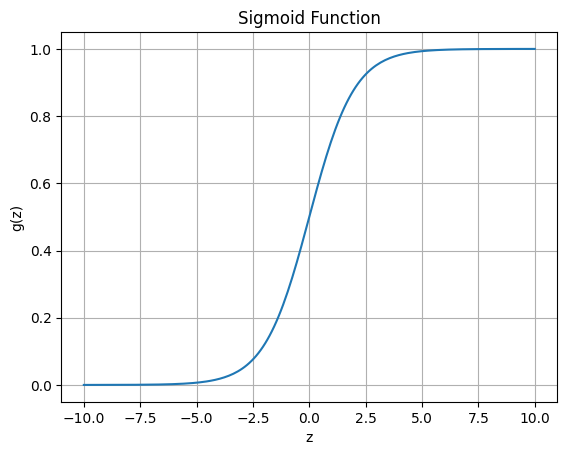

In [7]:
# verify with random values
z = np.linspace(-10, 10, 200)
g_val = g(z)

# plot
plt.plot(z, g_val)
plt.title("Sigmoid Function")
plt.xlabel("z")
plt.ylabel("g(z)")
plt.grid(True)
plt.show()

looks correct as with z=0 we get 0.5

#### d) Implement the hypothesis function $h_{\theta}(\mathbf{x})$

Hint: implement it so that the computation can take the full array $X$ with $h(\mathbf{x})$ broadcasted to all training samples.

In [8]:
def hyp(X, thetas):
    # with np.dot we multiply our weights with each sample. no need to transpose thetas
    return g(np.dot(X, thetas))

#### e) Implement the objective function $J(\theta)$

<center>$J(\theta) = \frac{1}{N} \sum_{n=1}^{N} y_{n} \log h_{\theta}(\mathbf{x_{n}}) + (1-y_{n}) \log (1 - h_{\theta} (\mathbf{x_{n}}))$</center>

In [9]:
# helps us to avoid numerical errors when log close to 0
epsilon = 1e-8


def J(X, y, thetas):
    h = hyp(X, thetas)
    return np.mean(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))

#### f) Implement the gradient ascent

In a similar way as in PW02 and PW03, implement the gradient ascent with the update rule:

<center>$\theta_{i} \leftarrow \theta_{i} + \alpha \frac{1}{N} \sum_{n=1}^{N} (y_{n} - h_{\theta}(\mathbf{x}_{n})) x_{n,i}$</center>

In [10]:
def grad(X, y, thetas):
    h = hyp(X, thetas)
    return (X.T @ (y - h)) / X.shape[0]

#### g) Test your implementation by running a gradient ascent

Hints: use a small $\alpha$. e.g. $0.001$,  store the evolution of the objective function $J(\theta)$ during the epochs to make a plot, use a large number of epochs, e.g. $2000000$.

In [11]:
def gradient_ascent(thetas, X, y, lr=0.001, epochs=2000000, record_every=100, tol=1e-7):
    thetas = np.r_[0.0, thetas]

    # will stor learning history
    history = []

    # last error made before computing new
    prev_J = J(X, y, thetas)

    for epoch in range(1, epochs + 1):

        # Ascent step
        thetas += lr * grad(X, y, thetas)

        # save to history every "record_every"
        if (epoch % record_every) == 0 or epoch == epochs:
            curr_J = J(X, y, thetas)
            history.append((epoch, curr_J))

            if epoch == record_every or epoch % 200000 == 0 or epoch == epochs:
                print(f"Epoch {epoch} | J = {curr_J:.4f} | Diff in J = {curr_J - prev_J:.3e}")

            # Early stop if not much improvement gained - !!! OVERFIT 
            if abs(curr_J - prev_J) < tol:
                break
            prev_J = curr_J

    return thetas, history


thetas0 = [0.0, 0.0]
thetas_fit, history = gradient_ascent(thetas0, X_train, y_train)

Epoch 100 | J = -0.6783 | Diff in J = 1.484e-02
Epoch 200000 | J = -0.2049 | Diff in J = 2.036e-06
Epoch 400000 | J = -0.2036 | Diff in J = 1.291e-07


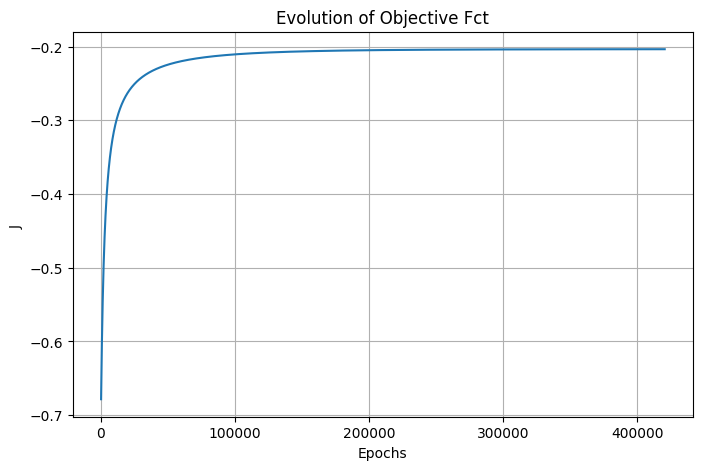

In [12]:
epochs = [e for e, _ in history]
J_values = [Jv for _, Jv in history]


plt.figure(figsize=(8, 5))
plt.plot(epochs, J_values)
plt.title("Evolution of Objective Fct")
plt.xlabel("Epochs")
plt.ylabel("J ")
plt.grid(True)
plt.show()

When analysing this graph we see that there is an evolution of J through the epochs and although it seemed that 200000 is too much, it stabilizes in the end.

#### h) Compute the correct classification rate on `student-dataset-test.csv`

Compute the correct classification rate on `student-dataset-test.csv` after convergence as you have an estimator of the posterior probabilities with:

<center>$P(y_{n}=1|\mathbf{x_{n}};\theta) = h_{\theta}(\mathbf{x_{n}})$</center>
<center>$P(y_{n}=0|\mathbf{x_{n}};\theta) = 1 - h_{\theta}(\mathbf{x_{n}})$</center>

This means that you can take the decisions $\hat{y}_{n} = 1$ if $h_{\theta}(\mathbf{x_{n}}) \geq 0.5$ and $\hat{y}_{n} = 0$ if $h_{\theta}(\mathbf{x_{n}}) < 0.5$.

In [13]:
# Normalize test set with training statistics first + add a ones col
X_test['x1'] = (X_test['x1'] - mean_train_x1) / std_deviation_train_x1
X_test['x2'] = (X_test['x2'] - mean_train_x2) / std_deviation_train_x2
X_test = pd.concat([pd.DataFrame(np.ones(len(X_test)), columns=["x0"]), pd.DataFrame(X_test[["x1", "x2"]]), ], axis=1, )

In [14]:
# if bigger than boundary = 0.5 then 1
boundary_decision = 0.5
# call hypothesis with best weights obtained
y_pred = hyp(X_test.values, thetas_fit) > boundary_decision

acc = (y_pred == y_test).mean()
print(f"Accuracy obtained is : {acc}")

Accuracy obtained is : 0.89


#### i) Draw the decision boundary

Draw the decision boundary of your system on top of the scatter plot of the testing data.

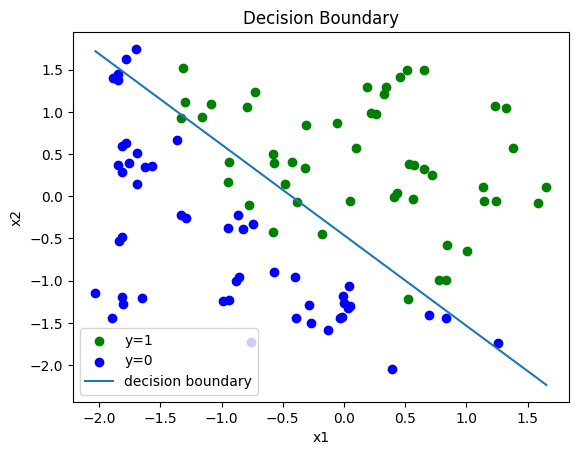

In [16]:
positive = (y_test == 1)

#pick only those with same index as positive for positive and vise versa
plt.scatter(X_test.loc[positive, 'x1'], X_test.loc[positive, 'x2'], c='green', label='y=1')
plt.scatter(X_test.loc[~positive, 'x1'], X_test.loc[~positive, 'x2'], c='blue', label='y=0')

# decision boundary is when z = 0
# start by getting values between min and max
x1 = np.linspace(X_test['x1'].min(), X_test['x1'].max(), 100)

# isolate x2 from the equation of z= .. as seen in theory
# if 0 = theta0 + theta1*x1 + theta2*x2
# then x2 = -(theta0 + theta1*x1)/ theta2
thetas_fit = np.array(thetas_fit)
x2 = -(thetas_fit[0] + thetas_fit[1] * x1) / thetas_fit[2]
plt.plot(x1, x2, label="decision boundary")

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Decision Boundary")
plt.legend()
plt.show()

we can visually see the 11 points that are miss classified

#### j) Compare the performance

Compare the performance of the logistic regression system with the ones of previous's week.

Comparaison des performances avec les semaines précédentes :

KNN : Dans notre expérience sur le dataset MNIST (ex2), la régression logistique atteint une précision d’environ 0.8905, ce qui reste légèrement inférieur au KNN du PW02 (0.9060). Cela montre que KNN peut parfois mieux gérer des frontières de décision non linéaires, mais il reste beaucoup plus coûteux à exécuter lorsque le volume de données augmente et nécessite de bien choisir le paramètre k.

Bayes : Par rapport à un classifieur Bayesien, la régression logistique a l’avantage de ne pas devoir modéliser explicitement les distributions p(x|C_k). Elle évite donc l’hypothèse d’indépendance entre les caractéristiques et les problèmes liés à la dimension des données. Cependant, Bayes reste théoriquement optimal lorsque ses hypothèses sont validées.

RegLinéaire : Contrairement à la régression linéaire qui prédit une valeur continue et n’est pas adaptée directement à la classification, la régression logistique utilise une fonction sigmoïde permettant de produire des probabilités et donc de décider plus naturellement entre les classes.

Donc la régression logistique représente un bon compromis car elle est simple, rapide à entraîner, fournit des probabilités d’appartenance aux classes et fonctionne bien lorsque la séparation reste globalement linéaire. 




### b. Optional - Stochastic gradient ascent

Redo the experiments of 2.a with a stochastic gradient ascent.

In [26]:
def gradient_ascent_sgd(thetas, X, y, lr=0.001, epochs=2000, record_every=25, tol=1e-7, shuffle=True):
    thetas = np.r_[0.0, np.asarray(thetas, dtype=np.float64).reshape(-1)]

    history = []
    prev_J = J(X, y, thetas)
    n = X.shape[0]

    for epoch in range(1, epochs + 1):
        # choose the randoms for stochastic
        idx = np.random.permutation(n) if shuffle else np.arange(n)
        for i in idx:
            xi = X.iloc[i].values  # shape (D,)
            yi = y.iloc[i]

            # dot product
            zi = xi @ thetas

            hi = g(zi)
            # single-sample gradient for ascent: (y - h) * x
            thetas += lr * (yi - hi) * xi

        if (epoch % record_every) == 0 or epoch == epochs:
            curr_J = J(X, y, thetas)
            history.append((epoch, curr_J))

            if epoch == record_every or epoch % 100 == 0 or epoch == epochs:
                print(f"Epoch {epoch} | J = {curr_J:.4f} | Diff in J = {curr_J - prev_J:.3e}")

            # early stopping, prevent overfitting by stopping early
            if abs(curr_J - prev_J) < tol:
                break
            prev_J = curr_J

    return thetas, history


thetas0 = [0.0, 0.0]
thetas_fit_sgd, history_sgd = gradient_ascent_sgd(thetas0, X_train, y_train)

Epoch 25 | J = -0.4684 | Diff in J = 2.248e-01
Epoch 100 | J = -0.3118 | Diff in J = 2.678e-02
Epoch 200 | J = -0.2625 | Diff in J = 7.943e-03
Epoch 300 | J = -0.2424 | Diff in J = 3.838e-03
Epoch 400 | J = -0.2314 | Diff in J = 2.254e-03
Epoch 500 | J = -0.2245 | Diff in J = 1.470e-03
Epoch 600 | J = -0.2198 | Diff in J = 1.023e-03
Epoch 700 | J = -0.2164 | Diff in J = 7.444e-04
Epoch 800 | J = -0.2139 | Diff in J = 5.594e-04
Epoch 900 | J = -0.2120 | Diff in J = 4.307e-04
Epoch 1000 | J = -0.2105 | Diff in J = 3.382e-04
Epoch 1100 | J = -0.2094 | Diff in J = 2.696e-04
Epoch 1200 | J = -0.2084 | Diff in J = 2.176e-04
Epoch 1300 | J = -0.2077 | Diff in J = 1.775e-04
Epoch 1400 | J = -0.2070 | Diff in J = 1.462e-04
Epoch 1500 | J = -0.2065 | Diff in J = 1.213e-04
Epoch 1600 | J = -0.2061 | Diff in J = 1.013e-04
Epoch 1700 | J = -0.2057 | Diff in J = 8.509e-05
Epoch 1800 | J = -0.2054 | Diff in J = 7.185e-05
Epoch 1900 | J = -0.2051 | Diff in J = 6.094e-05
Epoch 2000 | J = -0.2049 | Diff

In [27]:
# call hypothesis with best weights obtained - stochastic thetas
y_pred = hyp(X_test.values, thetas_fit_sgd) > boundary_decision

acc = (y_pred == y_test).mean()
print(f"Accuracy obtained is : {acc}")

Accuracy obtained is : 0.89


same accuracy obtained although training was way faster. we can see the positives of exploiting such technique

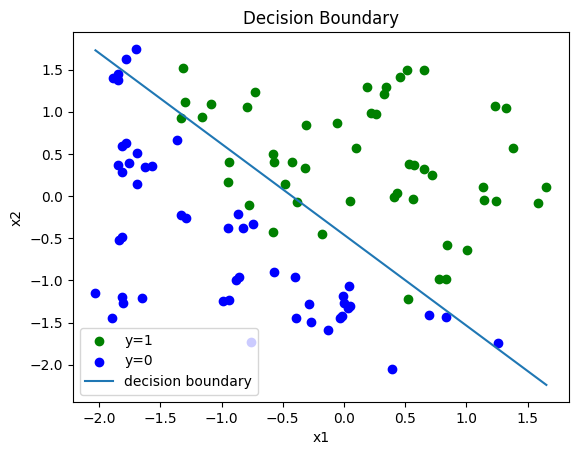

In [28]:
positive = (y_test == 1)

#pick only those with same index as positive for positive and vise versa
plt.scatter(X_test.loc[positive, 'x1'], X_test.loc[positive, 'x2'], c='green', label='y=1')
plt.scatter(X_test.loc[~positive, 'x1'], X_test.loc[~positive, 'x2'], c='blue', label='y=0')

# decision boundary is when z = 0
x1 = np.linspace(X_test['x1'].min(), X_test['x1'].max(), 100)

# isolate x2 from the equation of z= .. as seen in theory
# if 0 = theta0 + theta1*x1 + theta2*x2
# then x2 = -(theta0 + theta1*x1)/ theta2
x2 = -(thetas_fit_sgd[0] + thetas_fit_sgd[1] * x1) / thetas_fit_sgd[2]
plt.plot(x1, x2, label="decision boundary")

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Decision Boundary")
plt.legend()
plt.show()

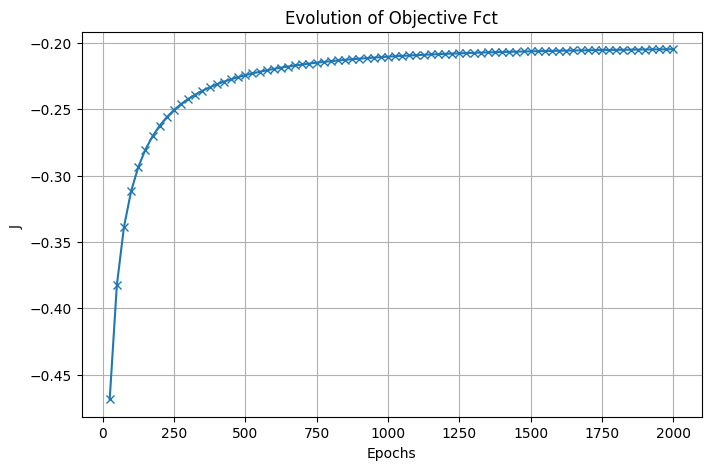

In [29]:
epochs = [e for e, _ in history_sgd]
J_values = [Jv for _, Jv in history_sgd]


plt.figure(figsize=(8, 5))
plt.plot(epochs, J_values, marker='x')
plt.title("Evolution of Objective Fct")
plt.xlabel("Epochs")
plt.ylabel("J ")
plt.grid(True)
plt.show()

This graph shows how quickly the stochastic models stabilize over the epochs, with the batch size of 2000 converging much faster than the full-batch model to achieve good results.

### c. Logistic regression classifier with non-linear decision boundary

Redo the experiments of 2.a by increasing the complexity of the model in order to have a non-linear decision boundary:

<center>$h_{\theta}(\mathbf{x}) = g(\theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} + \theta_{3} x_{1}^{2} + \theta_{4} x_{2}^{2} + \theta_{5} x_{1}x_{2} + \ldots)$</center>

We start by preparing new features 

In [30]:
X_train["x1^2"] = X_train["x1"] ** 2
X_train["x2^2"] = X_train["x2"] ** 2
X_train["x1*x2"] = X_train["x1"] * X_train["x2"]

X_test["x1^2"] = X_test["x1"] ** 2
X_test["x2^2"] = X_test["x2"] ** 2
X_test["x1*x2"] = X_test["x1"] * X_test["x2"]

call gradient descent for each theta, 5 now

In [ ]:
# x1,x2 ... x1*x2
thetas0 = [0.0, 0.0, 0.0, 0.0, 0.0]
thetas_nonlin, history_nonlin = gradient_ascent(thetas0, X_train, y_train)

Epoch 100 | J = -0.6781 | Diff in J = 1.507e-02
Epoch 200000 | J = -0.1109 | Diff in J = 1.901e-05


In [131]:
y_pred = hyp(X_test, thetas_nonlin) > boundary_decision
acc = (y_pred == y_test).mean()
print(f"Accuracy obtained with round boundary is : {acc}")

Accuracy obtained with round boundary is : 0.95


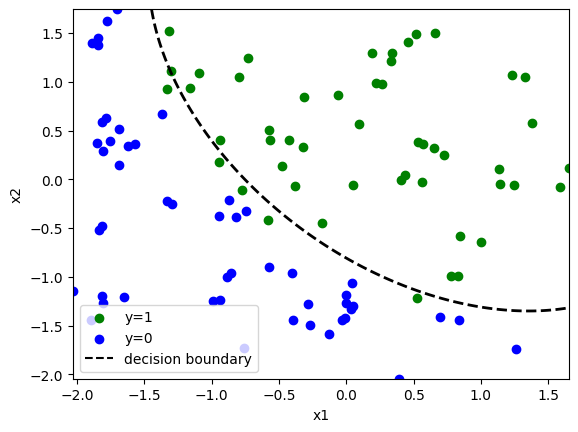

In [132]:
# scatter test points
positive = (y_test == 1)
plt.scatter(X_test.loc[positive, 'x1'], X_test.loc[positive, 'x2'], c='green', label='y=1')
plt.scatter(X_test.loc[~positive, 'x1'], X_test.loc[~positive, 'x2'], c='blue', label='y=0')


# build a grid over the x1/x2 ranges
x1_min, x1_max = X_test['x1'].min(), X_test['x1'].max()
x2_min, x2_max = X_test['x2'].min(), X_test['x2'].max()
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 300),
                       np.linspace(x2_min, x2_max, 300))

thetas_nonlin = np.array(thetas_nonlin, dtype=float)

# bias, θ_x1, θ_x2, θ_x1^2, θ_x2^2, θ_x1*x2
zz = (thetas_nonlin[0]
      + thetas_nonlin[1] * xx1
      + thetas_nonlin[2] * xx2
      + thetas_nonlin[3] * (xx1 ** 2)
      + thetas_nonlin[4] * (xx2 ** 2)
      + thetas_nonlin[5] * (xx1 * xx2))

# draw the circle where z=0 ( with probability = 0.5)
cs = plt.contour(xx1, xx2, zz, levels=[0], colors='k', linewidths=2, linestyles='--')
plt.plot([], [], 'k--', label='decision boundary')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Decision Boundary")
plt.legend()
plt.show()

Visually we see that the model now produces a non-linear decision boundary that aligns better with the true separation of the data. This increased complexity allows to better capture the patterns thus achieve better results

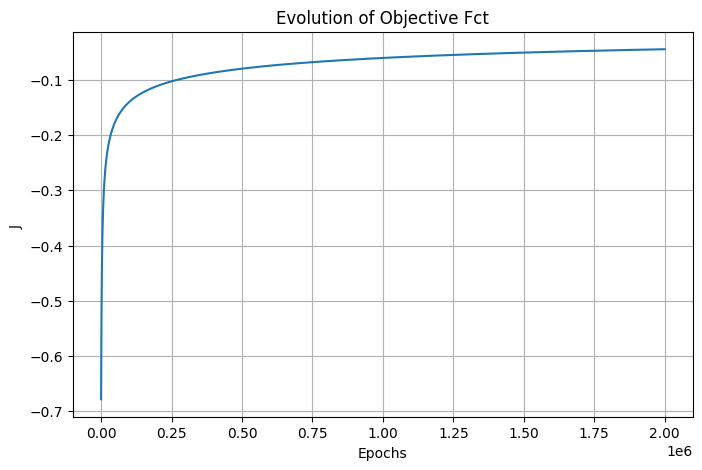

In [133]:
epochs = [e for e, _ in history_nonlin]
J_values = [Jv for _, Jv in history_nonlin]


plt.figure(figsize=(8, 5))
plt.plot(epochs, J_values)
plt.title("Evolution of Objective Fct")
plt.xlabel("Epochs")
plt.ylabel("J ")
plt.grid(True)
plt.show()


### d. Using SciKit Learn

Redo one of the exercise a. or c. using SciKit Learn.

1. Read the documentation of the function `SGDClassifier()` available in the toolkit SciKit Learn. This function implements stochastic gradient descent training for different linear systems such as Logistic Regression. For a logistic regression, the `loss` parameter should be set to `"log"`.
1. Use the `fit()` and `predict()` methods of this classifier on the student data.
1. Compute the performances and compare it to your own implementations.

In [134]:
model = SGDClassifier(loss="log_loss", max_iter=2000000, eta0=0.001, random_state=42  )
model.fit(X_train[["x1", "x2"]], y_train)
y_pred = model.predict(X_test[["x1", "x2"]])


accuracy = (y_pred == y_test).mean()
print(f"Accuracy with library : {accuracy:.2f}")

Accuracy with library : 0.89


we ran this several times and the performance changes quite often, given that it is stochastic. We then added random_state 42 for reproductibility

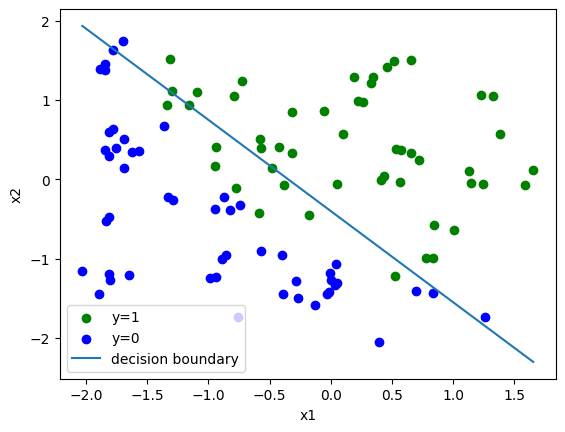

In [135]:
plt.scatter(X_test.loc[positive, 'x1'],  X_test.loc[positive, 'x2'],  c='green', label='y=1')
plt.scatter(X_test.loc[~positive, 'x1'], X_test.loc[~positive, 'x2'], c='blue',  label='y=0')

# get the thetas from the model
theta_0, theta_1 = model.coef_[0]
b = model.intercept_[0]

x1 = np.linspace(X_test['x1'].min(), X_test['x1'].max(), 200)
# isolate x2 from x1
x2 = -(b + theta_0*x1) / theta_1

plt.plot(x1, x2, label='decision boundary')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Decision Boundary")
plt.legend()
plt.show()